#Automated Keyword Extraction from Articles using NLP


Background
In research & news articles, keywords form an important component since they provide a concise representation of the article’s content. Keywords also play a crucial role in locating the article from information retrieval systems, bibliographic databases and for search engine optimization. Keywords also help to categorize the article into the relevant subject or discipline.

Conventional approaches of extracting keywords involve manual assignment of keywords based on the article content and the authors’ judgment. This involves a lot of time & effort and also may not be accurate in terms of selecting the appropriate keywords. With the emergence of Natural Language Processing (NLP), keyword extraction has evolved into being effective as well as efficient.

And in this article, we will combine the two — we’ll be applying NLP on a collection of articles to extract keywords.

#About the dataset

In this article, we will be extracting keywords from a dataset that contains about 3,800 abstracts. The original dataset is from Kaggle — NIPS Paper. Neural Information Processing Systems (NIPS) is one of the top machine learning conferences in the world. This dataset includes the title and abstracts for all NIPS papers to date (ranging from the first 1987 conference to the current 2016 conference).

The original dataset also contains the article text. However, since the focus is on understanding the concept of keyword extraction and using the full article text could be computationally intensive, only abstracts have been used for NLP modelling. The same code block can be used on the full article text to get a better and enhanced keyword extraction.


#High-level approach


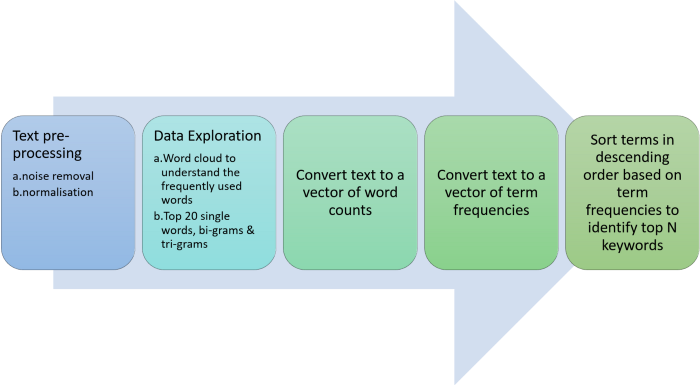

#Importing the dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('/content/sample_data/papers.csv')

data.head(10)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


dropping the variables we will not work on in this article

In [3]:
data = data.drop(['title','event_type','pdf_name','paper_text'], axis = 1) 

In [4]:
dataset = data[data.abstract != 'Abstract Missing']

In [6]:
dataset.to_csv(r'/content/sample_data/paper2.csv',index = False)

In [9]:
dataset = pd.read_csv("/content/sample_data/paper2.csv")

In [10]:
dataset.head()

,id,year,abstract
0,1861,2000,Non-negative matrix factorization (NMF) has pr...
1,1975,2001,Spike-triggered averaging techniques are effec...
2,3163,2007,It is known that determinining whether a DEC-P...
3,3164,2007,We present the first truly polynomial algorith...
4,3167,2007,Semi-supervised inductive learning concerns ho...


#Preliminary text exploration

Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

#Fetch word count for each abstract

In [11]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['abstract'].apply(lambda x: len(str(x).split(" ")))
dataset[['abstract','word_count']].head()

,abstract,word_count
0,Non-negative matrix factorization (NMF) has pr...,107
1,Spike-triggered averaging techniques are effec...,81
2,It is known that determinining whether a DEC-P...,67
3,We present the first truly polynomial algorith...,143
4,Semi-supervised inductive learning concerns ho...,119


In [12]:
##Descriptive statistics of word counts
dataset.word_count.describe()

count    3924.000000
mean      148.390928
std        45.605755
min        19.000000
25%       116.000000
50%       143.000000
75%       177.000000
max       317.000000
Name: word_count, dtype: float64

The average word count is about 148 words per abstract. The word count ranges from a minimum of 19 to a maximum of 317. The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.

#Most common and uncommon words

A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [14]:
#Identify common words
freq = pd.Series(' '.join(dataset['abstract']).split()).value_counts()[:20]
freq

the         29793
of          20918
a           16339
and         13626
to          12869
in           8980
that         7838
is           7666
for          7169
We           6238
on           5579
we           5167
with         4512
this         3677
as           3643
are          3529
an           3366
by           3197
can          2953
learning     2825
dtype: int64

In [16]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['abstract']).split()).value_counts()[-20:]
freq1

(equality)           1
92.60%,              1
ADNI                 1
\Omega(\epsilon)$    1
nuclear-norm.        1
Moran                1
(SQuAD).             1
)$.                  1
away-steps.          1
$\Theta              1
well-posed,          1
metric-dependent     1
(Ratcliff,           1
g                    1
$S_k$                1
(?dish?).            1
Re-Identification    1
subsymbolic          1
incentives.          1
deepened             1
dtype: int64

#Text Pre-processing

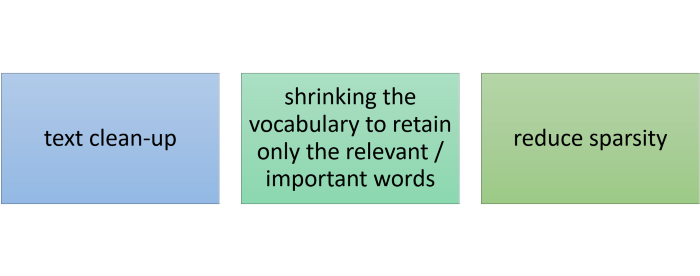

####**Sparsity:** In text mining, huge matrices are created based on word frequencies with many cells having zero values. This problem is called sparsity and is minimized using various techniques.


Text pre-processing can be divided into two broad categories — noise removal & normalization. Data components that are redundant to the core text analytics can be considered as noise.



Text pre-processing can be divided into two broad categories — noise removal & normalization. Data components that are redundant to the core text analytics can be considered as noise.

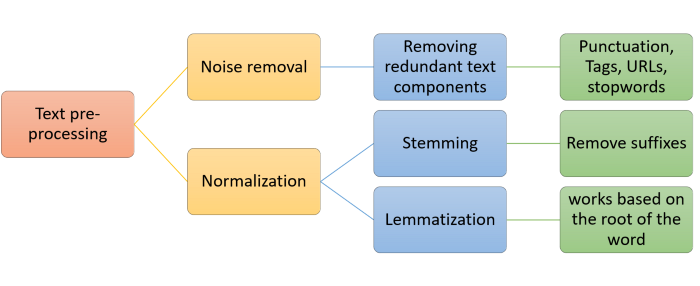

Handling multiple occurrences / representations of the same word is called normalization. There are two types of normalization — stemming and lemmatization. Let us consider an example of various versions of the word learn — learn, learned, learning, learner. Normalisation will convert all these words to a single normalised version — “learn”.

Stemming normalizes text by removing suffixes.

Lemmatisation is a more advanced technique which works based on the root of the word.



The following example illustrates the way stemming and lemmatisation work:

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [19]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


To carry out text pre-processing on our dataset, we will first import the required libraries.


In [20]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Removing stopwords:** Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.


There is a default list of stopwords in python nltk library. In addition, we might want to add context specific stopwords for which the “most common words” that we listed in the beginning will be helpful. We will now see how to create a list of stopwords and how to add custom stopwords:

In [21]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [22]:
corpus = []
for i in range(0, 3847):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Let us now view an item from the corpus:


In [25]:
#View corpus item
corpus[222]


'actor critic algorithm reinforcement learning achieving renewed popularity due good convergence property situation approach often fail e g function approximation involved interestingly growing evidence actor critic approach based phasic dopamine signal play key role biological learning cortical basal ganglion derive temporal difference based actor critic learning algorithm convergence proved without assuming separate time scale actor critic approach demonstrated applying network spiking neuron established relation phasic dopamine temporal difference signal lends support biological relevance algorithm'

# Data Exploration

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.


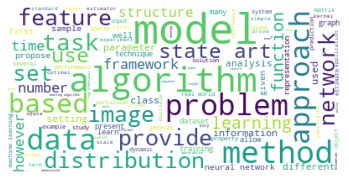

In [27]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1500)

#Text preparation

Text in the corpus needs to be converted to a format that can be interpreted by the machine learning algorithms. There are 2 parts of this conversion — Tokenisation and Vectorisation.


*Tokenisation is the process of converting the continuous text into a list of words. The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction.*


For text preparation we use the bag of words model which ignores the sequence of the words and only considers word frequencies.

#Creating a vector of word counts


As the first step of conversion, we will use the CountVectoriser to tokenise the text and build a vocabulary of known words. We first create a variable “cv” of the CountVectoriser class, and then evoke the fit_transform function to learn and build the vocabulary.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

Let us now understand the parameters passed into the function:

* cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))

* max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

* max_features — determines the number of columns in the matrix.

* n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

An encoded vector is returned with a length of the entire vocabulary.

In [29]:
list(cv.vocabulary_.keys())[:10]

['non',
 'negative',
 'matrix',
 'factorization',
 'nmf',
 'useful',
 'decomposition',
 'multivariate',
 'data',
 'different']

#Visualize top N uni-grams, bi-grams & tri-grams

We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

[Text(0, 0, 'model'),
 Text(0, 0, 'algorithm'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'method'),
 Text(0, 0, 'problem'),
 Text(0, 0, 'data'),
 Text(0, 0, 'approach'),
 Text(0, 0, 'function'),
 Text(0, 0, 'based'),
 Text(0, 0, 'network'),
 Text(0, 0, 'time'),
 Text(0, 0, 'paper'),
 Text(0, 0, 'result'),
 Text(0, 0, 'task'),
 Text(0, 0, 'distribution'),
 Text(0, 0, 'propose'),
 Text(0, 0, 'state'),
 Text(0, 0, 'feature'),
 Text(0, 0, 'image'),
 Text(0, 0, 'performance'),
 Text(0, 0, 'bound'),
 Text(0, 0, 'set'),
 Text(0, 0, 'number'),
 Text(0, 0, 'inference'),
 Text(0, 0, 'linear')]

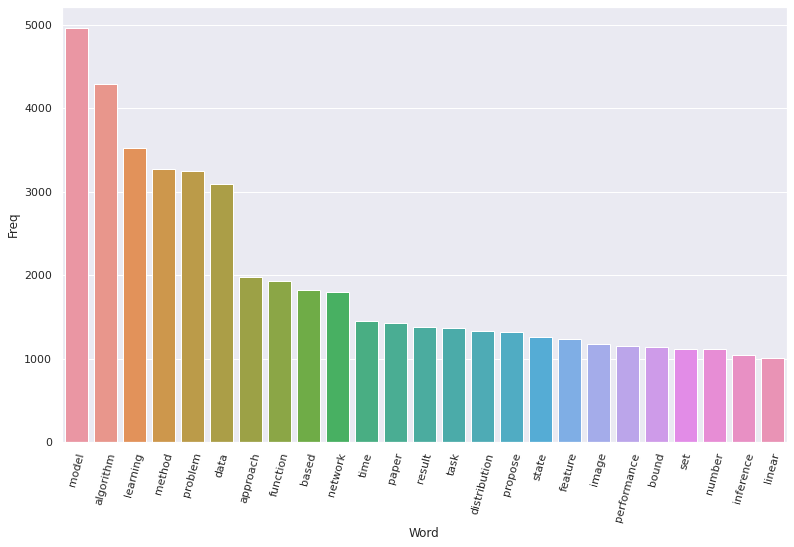

In [41]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=25)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

                   Bi-gram  Freq
0                state art   701
1           neural network   547
2         machine learning   401
3               real world   364
4       learning algorithm   342
5         high dimensional   320
6              lower bound   252
7                 data set   232
8            paper propose   232
9          graphical model   222
10     experimental result   219
11    optimization problem   215
12           loss function   205
13  reinforcement learning   201
14                low rank   197
15        gradient descent   184
16        learning problem   180
17        gaussian process   179
18     stochastic gradient   170
19             monte carlo   170


[Text(0, 0, 'state art'),
 Text(0, 0, 'neural network'),
 Text(0, 0, 'machine learning'),
 Text(0, 0, 'real world'),
 Text(0, 0, 'learning algorithm'),
 Text(0, 0, 'high dimensional'),
 Text(0, 0, 'lower bound'),
 Text(0, 0, 'data set'),
 Text(0, 0, 'paper propose'),
 Text(0, 0, 'graphical model'),
 Text(0, 0, 'experimental result'),
 Text(0, 0, 'optimization problem'),
 Text(0, 0, 'loss function'),
 Text(0, 0, 'reinforcement learning'),
 Text(0, 0, 'low rank'),
 Text(0, 0, 'gradient descent'),
 Text(0, 0, 'learning problem'),
 Text(0, 0, 'gaussian process'),
 Text(0, 0, 'stochastic gradient'),
 Text(0, 0, 'monte carlo')]

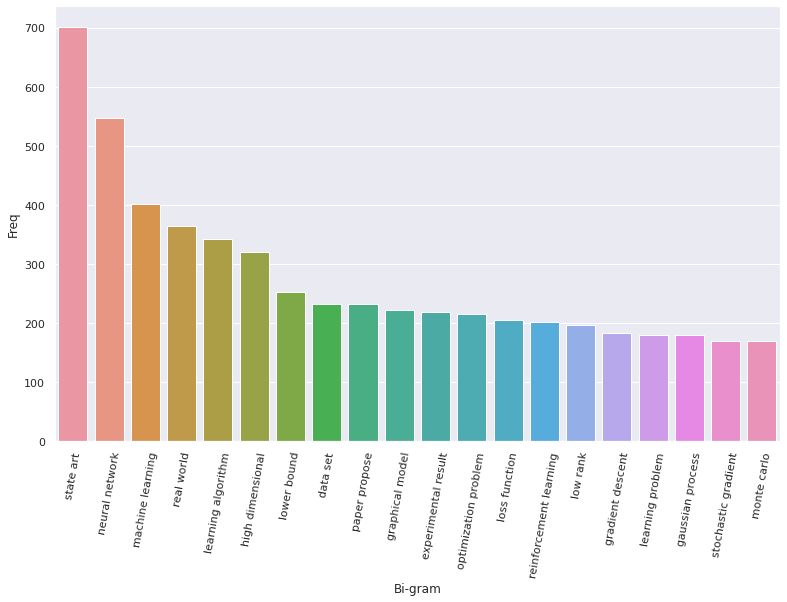

In [39]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=80)

                        Tri-gram  Freq
0   convolutional neural network   100
1            deep neural network    94
2          state art performance    82
3    stochastic gradient descent    80
4            real world datasets    76
5               state art method    72
6       recurrent neural network    70
7                real world data    68
8        markov decision process    63
9                low rank matrix    62
10          synthetic real world    61
11            multi armed bandit    60
12         outperforms state art    60
13      semi supervised learning    59
14         latent variable model    55
15            markov chain monte    55
16             chain monte carlo    55
17              state art result    55
18  principal component analysis    50
19   empirical risk minimization    50


[Text(0, 0, 'convolutional neural network'),
 Text(0, 0, 'deep neural network'),
 Text(0, 0, 'state art performance'),
 Text(0, 0, 'stochastic gradient descent'),
 Text(0, 0, 'real world datasets'),
 Text(0, 0, 'state art method'),
 Text(0, 0, 'recurrent neural network'),
 Text(0, 0, 'real world data'),
 Text(0, 0, 'markov decision process'),
 Text(0, 0, 'low rank matrix'),
 Text(0, 0, 'synthetic real world'),
 Text(0, 0, 'multi armed bandit'),
 Text(0, 0, 'outperforms state art'),
 Text(0, 0, 'semi supervised learning'),
 Text(0, 0, 'latent variable model'),
 Text(0, 0, 'markov chain monte'),
 Text(0, 0, 'chain monte carlo'),
 Text(0, 0, 'state art result'),
 Text(0, 0, 'principal component analysis'),
 Text(0, 0, 'empirical risk minimization')]

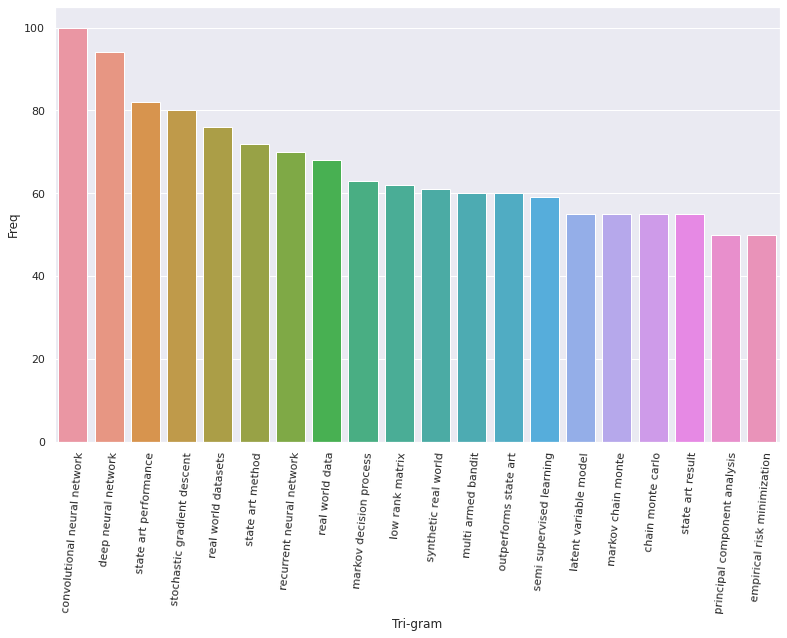

In [42]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=85)

#Converting to a matrix of integers

The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

TF-IDF consists of 2 components:

TF — term frequency

IDF — Inverse document frequency



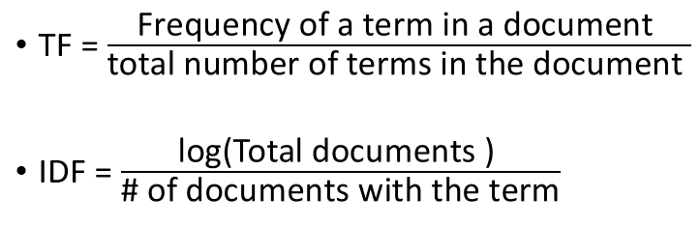Image for post

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[532]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [44]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
present theory compositionality stochastic optimal control showing task optimal controller constructed certain primitive primitive feedback controller pursuing agenda mixed proportion much progress making towards agenda compatible agenda present task resulting composite control law provably optimal problem belongs certain class class rather general yet number unique property bellman equation made linear even non linear discrete dynamic give rise compositionality developed special case linear dynamic gaussian noise framework yield analytical solution e non linear mixture linear quadratic regulator without requiring final cost quadratic generally natural set control primitive constructed applying svd green function bellman equation illustrate theory context human arm movement idea optimality compositionality prominent field motor control yet hard reconcile work make possible

Keywords:
compositionality 0.325
primitive 0.291
control 0.254
linear 0.212
controller 0.197


#Concluding remarks

Ideally for the IDF calculation to be effective, it should be based on a large corpora and a good representative of the text for which the keywords need to be extracted. In our example, if we use the full article text instead of the abstracts, the IDF extraction would be much more effective. However, considering the size of the dataset, I have limited the corpora to just the abstracts for the purpose of demonstration.


This is a fairly simple approach to understand fundamental concepts of NLP and to provide a good hands-on practice with some python codes on a real-life use case. The same approach can be used to extract keywords from news feeds & social media feeds.